In [1]:
!git clone https://github.com/teddyalexandre/Laplace-Redux.git

fatal: destination path 'Laplace-Redux' already exists and is not an empty directory.


In [2]:
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
import numpy as np
import torch
import matplotlib.pyplot as plt

from laplace import Laplace, marglik_training

from Laplace.examples.helper.dataloaders import get_sinusoid_example
from Laplace.examples.helper.util import plot_regression
from tqdm import tqdm
torch.manual_seed(711)
# sample toy data example
sigma = 0.5
#my_func = lambda x: -(torch.sin((x-5))+0.1*(x-5))**2+5
X_train, y_train, train_loader, X_test = get_sinusoid_example(sigma_noise=0.3)

#X_train, y_train, train_loader, X_test = get_my_func_example(my_func, -10, 20, n_data=500, sigma_noise=sigma, batch_size=500)

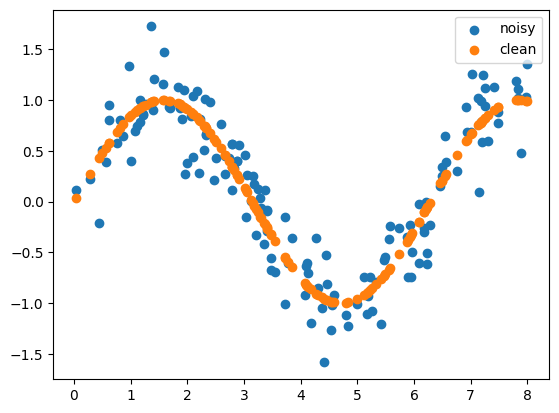

In [3]:
plt.scatter(X_train, y_train, label="noisy")
plt.scatter(X_train, torch.sin(X_train), label="clean")
plt.legend()
plt.show()

# simple example of uncertainty quantification

## LA for pretrained MAP

Defining a mini NN

In [4]:
def get_model():
    torch.manual_seed(711)
    # 1->50 -> tanh -> 50 -> 1
    return torch.nn.Sequential(
        torch.nn.Linear(1, 50), torch.nn.Tanh(), torch.nn.Linear(50, 1)
    )
model = get_model()

Fit to sine. We obtain a MAP estimator.

In [5]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


n_epochs = 1000
for i in tqdm(range(n_epochs)):
    for X, y in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()

  2%|▏         | 21/1000 [00:00<00:09, 104.47it/s]

100%|██████████| 1000/1000 [00:03<00:00, 264.49it/s]


In [6]:
la = Laplace(model, 'regression', subset_of_weights='all', hessian_structure='full')

# fitting LA to the parameters of the model
la.fit(train_loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [7]:
type(la)

laplace.baselaplace.FullLaplace

In [8]:
x = X_test.flatten().cpu().numpy()
f_mu, f_var = la(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)
pred_mlp = model(X_test).detach().cpu().numpy()

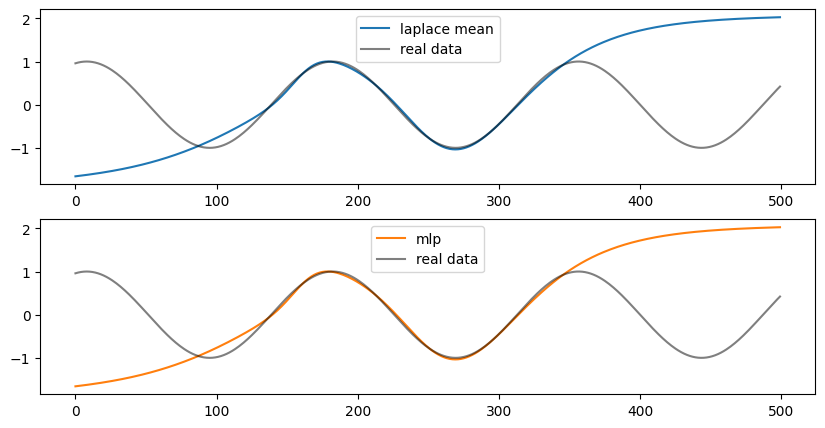

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(f_mu, label="laplace mean")
plt.plot(np.sin(x), label="real data", c="black", alpha=0.5)
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(pred_mlp, label="mlp", c= "#ff7f0e")
plt.plot(np.sin(x), label="real data", c='black', alpha=0.5)
plt.legend()

plt.show()

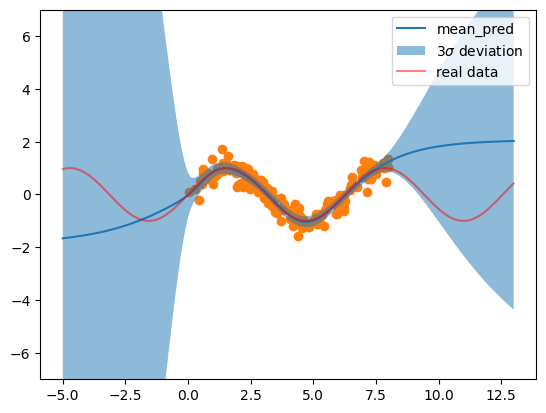

In [10]:
plt.plot(x, f_mu, label="mean_pred")
plt.scatter(X_train, y_train, c="#ff7f0e")
plt.fill_between(x, f_mu-3*f_sigma, f_mu+3*f_sigma, alpha=0.5, label=r"$3\sigma$ deviation")
plt.plot(x, np.sin(x), label="real data", c="r", alpha=0.5)
plt.ylim(-7, 7)
plt.legend()
plt.show()

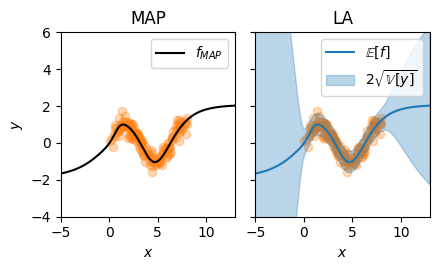

In [11]:
plot_regression(X_train, y_train, x, f_mu, pred_std)

## Online empirical Bayes

Training takes ~35 seconds on my CPU

Added logging support + option to lig into a file from a Jupyter notebook

In [12]:
from importlib import reload
import logging


# doest not work for ipynb
reload(logging)
logging.basicConfig(filename='training_sinusoidal.log', filemode='w', level=logging.INFO)

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol V from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol V from STIXNonUnicode


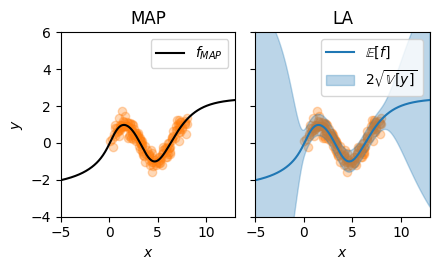

In [38]:
model = get_model()
la, model, margliks, losses = marglik_training(
    model=model, train_loader=train_loader, likelihood='regression',
    hessian_structure='full', backend=BackPackGGN, n_epochs=n_epochs, 
    optimizer_kwargs={'lr': 1e-2}, prior_structure='scalar'
)

f_mu, f_var = la(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

plot_regression(X_train, y_train, x, f_mu, pred_std)

## Post-hoc Laplace on a large image classifier 

Supposedly only works with cuda

Slightly Rewritten for a recent mumpy support

In [19]:
import torch
import torch.distributions as dists
import numpy as np
import Laplace.examples.helper.wideresnet as wrn
import Laplace.examples.helper.dataloaders as dl
from Laplace.examples.helper import util
from netcal.metrics import ECE

from laplace import Laplace


np.random.seed(7777)
torch.manual_seed(7777)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

train_loader = dl.CIFAR10(train=True)
test_loader = dl.CIFAR10(train=False)
targets = torch.cat([y for x, y in test_loader], dim=0)

100%|██████████| 170498071/170498071 [00:08<00:00, 19243055.46it/s]


Extracting ./temp/cifar-10-python.tar.gz to ./temp/
Files already downloaded and verified


In [23]:
model = wrn.WideResNet(16, 4, num_classes=10).eval()

util.download_pretrained_model()
model.load_state_dict(torch.load('./temp/CIFAR10_plain.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

Probabilities for each batch

In [48]:
@torch.no_grad()
def predict(dataloader, model, laplace=False):
    py = []

    for x, _ in dataloader:
        if laplace:
            py.append(model(x))
        else:
            py.append(torch.softmax(model(x), dim=-1))

    return torch.cat(py).cpu()

Takes ~1m on my CPU

In [45]:
probs_map = predict(test_loader, model, laplace=False)
acc_map = (probs_map.argmax(-1) == targets).numpy().astype(float).mean()
ece_map = ECE(bins=15).measure(probs_map.numpy(), targets.numpy())
nll_map = -dists.Categorical(probs_map).log_prob(targets).mean()

print(f'[MAP] Acc.: {acc_map:.1%}; ECE: {ece_map:.1%}; NLL: {nll_map:.3}')

[MAP] Acc.: 94.8%; ECE: 2.0%; NLL: 0.172


In [29]:
targets

array([3, 8, 8, ..., 5, 1, 7], dtype=int64)

Adding Laplace approximation for the last layer
Took ~10.5 min on my CPU

In [46]:
la = Laplace(model, 'classification',
             subset_of_weights='last_layer',
             hessian_structure='kron')
la.fit(train_loader)
la.optimize_prior_precision(method='marglik')

In [49]:
probs_laplace = predict(test_loader, la, laplace=True)
acc_laplace = (probs_laplace.argmax(-1) == targets).numpy().astype(float).mean()
ece_laplace = ECE(bins=15).measure(probs_laplace.numpy(), targets.numpy())
nll_laplace = -dists.Categorical(probs_laplace).log_prob(targets).mean()

print(f'[Laplace] Acc.: {acc_laplace:.1%}; ECE: {ece_laplace:.1%}; NLL: {nll_laplace:.3}')

[Laplace] Acc.: 94.8%; ECE: 0.8%; NLL: 0.157
